<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

**Цель проекта:** построить модель для предсказания количество заказов такси на следующий час.

**Критерий качества:** значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Загрузка библиотек:

In [94]:
!pip install scikit-learn==1.5.0 -q
!pip install optuna -q

In [95]:
import sklearn
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import optuna

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from lightgbm import early_stopping

RANDOM_STATE=42

## Подготовка данных

**Загрузка данных, изучение информации**.

Загружаем данные и сохраняем в датарейм df_taxi:

In [3]:
df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
display(df_taxi.head(5))
df_taxi.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Описание данных**:

- 'num_orders' - количество заказов;
- 'datetime' - дата и время заказа.

**Вывод**: 

В датафрейме 26496 строк, 2 столбца. Пропусков нет, наименование столбцов корректное. Даты в столбце записаны в формате datetime. Интервал временной в данных - каждые 10 минут.

**Проверка наличия явных дубликатов**.

In [5]:
print(f'''Количество явных дубликатов: {df_taxi.duplicated().sum()}''')

Количество явных дубликатов: 0


**Перезапись файла в датафрейм, назначив даты индексом:**

In [6]:
df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [7]:
display(df_taxi.head(5))
df_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Проверка индексов на монотонность (хронологический порядок):**

In [8]:
print(f'''Хронологический порядок соблюден: {df_taxi.index.is_monotonic}''')

Хронологический порядок соблюден: True


**Функции для визуализации данных:**

In [9]:
sns.set(rc={'figure.figsize': (17, 4)})
sns.set_palette('PRGn')

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.show()

In [10]:
def viz_decompose(decomposed):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    decomposed.trend.plot(ax=plt.gca(), grid=True)
    plt.title('Тренд')
    plt.subplot(132)
    decomposed.seasonal.plot(ax=plt.gca(), grid=True)
    plt.title('Сезонность')
    plt.subplot(133)
    decomposed.resid.plot(ax=plt.gca(), grid=True)
    plt.title('Остатки')
    plt.tight_layout()

**Общее распределение заказов и статистические характеристики:**

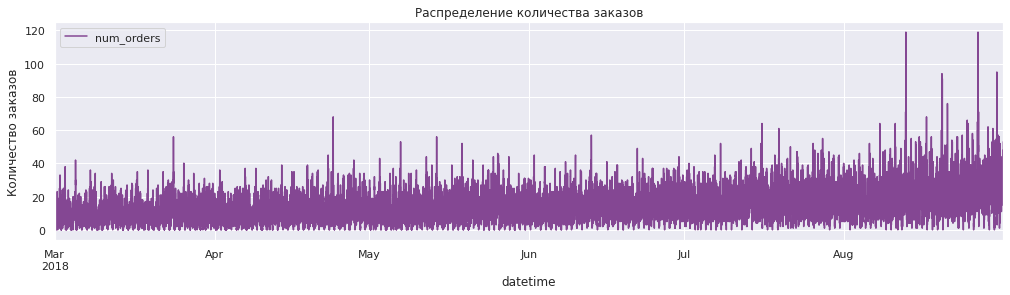

Статистические характеристики:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [11]:
lineplot(df_taxi, 'Распределение количества заказов')
print('Статистические характеристики:')
df_taxi.describe()

Вывод: минимальное количество заказов - ноль, максимальное - 119 заказов. Среднее - 14 заказов, медиана - 13 заказов. Отклонений в значениях нет.

**Ресемплирование данных по одному часу и подсчет суммарного значения для каждой группы**:

In [12]:
df_taxi_res_hour = df_taxi.resample('1H').sum()
df_taxi_res_hour.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Ресемплирование по одному часу выполнено успешно.

**Вывод по разделу:**

**На этапе подготовки данных было выполнено:**
1. **Загрузка данных, изучение информации**. Файл загружен в датафрейм (df_taxi), который имеет 26496 строк, 2 столбца (дата и количество заказов). Пропусков нет, наименование столбцов корректное. Интервал временной в данных - каждые 10 минут.

2. **Проверка наличия явных дубликатов.** Отсутствуют.

3. **Перезапись файла в датафрейм, назначив даты индексом.** Успешно выполнено.

4. **Проверка индексов на монотонность (хронологический порядок)**. Хронологический порядок соблюден.

5. **Созданы функции для визуализации данных**.

6. **Визуализировано общее распределение заказов и выведены статистические характеристики**. Минимальное количество заказов - ноль, максимальное - 119 заказов. Среднее - 14 заказов, медиана - 13 заказов. Отклонений в значениях нет.

7. **Ресемплирование данных по одному часу и подсчет суммарного значения для каждой группы**. Успешно выполнено.

## Анализ данных

Посмотрим на распределение количества заказов по часам:

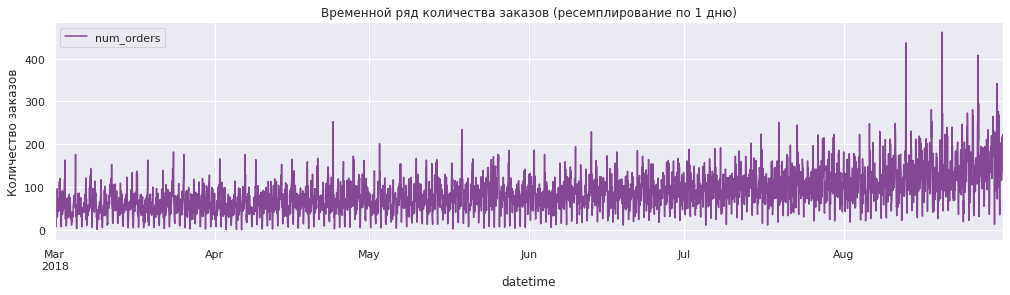

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [13]:
lineplot(df_taxi_res_hour, 'Временной ряд количества заказов (ресемплирование по 1 дню)')
df_taxi_res_hour.describe()

Общее количество часов в данных - 4416 ч. В среднем в час поступает 84 заказа, минимальное количество - ноль, максимальное - 462 заказа. Временной ряд на графике имеет множественные колебания.

**Декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции:**

In [14]:
decomposed_hour = seasonal_decompose(df_taxi_res_hour)

Визуализируем составляющие:

Составляющие декомпозиции (ресемплирование по 1 часу)


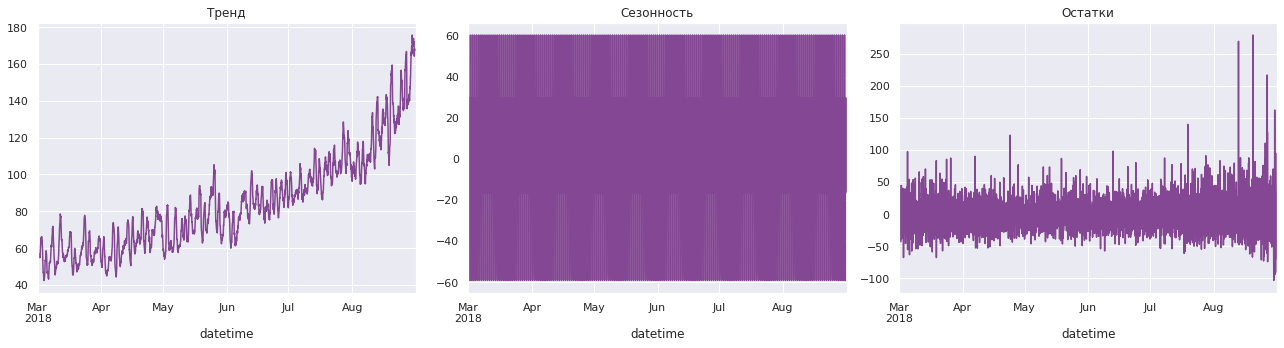

In [15]:
viz_decompose(decomposed_hour)
print('Составляющие декомпозиции (ресемплирование по 1 часу)')

Видно увеличение спроса на такси с марта по конец августа. 

Сезонность на таком диапазоне данных сложно интерпретировать, поэтому ниже рассмотрим ее на более коротком промежутке времени, например в рамках 1 месяца.

Сильные колебания остатков указывают на наличие пиковых значений.

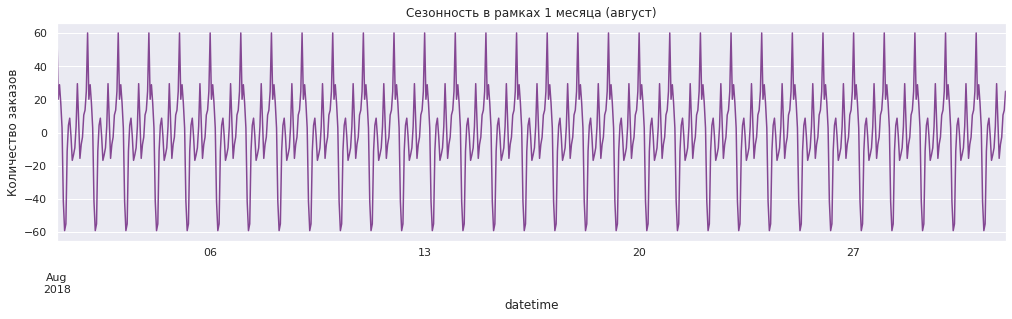

In [16]:
lineplot(decomposed_hour.seasonal['2018-08-01':'2018-08-31'], 'Сезонность в рамках 1 месяца (август)')

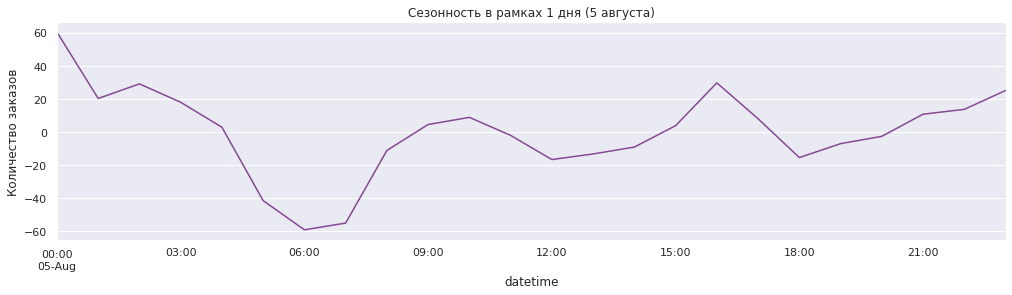

In [17]:
lineplot(decomposed_hour.seasonal['2018-08-05':'2018-08-05'], 'Сезонность в рамках 1 дня (5 августа)')

Видна цикличная закономерность - количество заказов к вечеру увеличивается, утром идет спад. Наибольший пик идет ближе к 2 часам ночи.

Проверим как зависит количество вызовов такси от для недели. **Делаем ресемплирование по 1 дню:**

In [18]:
df_taxi_res_day = df_taxi.resample('1D').sum()
df_taxi_res_day.head(10)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441
2018-03-08,1659
2018-03-09,1076


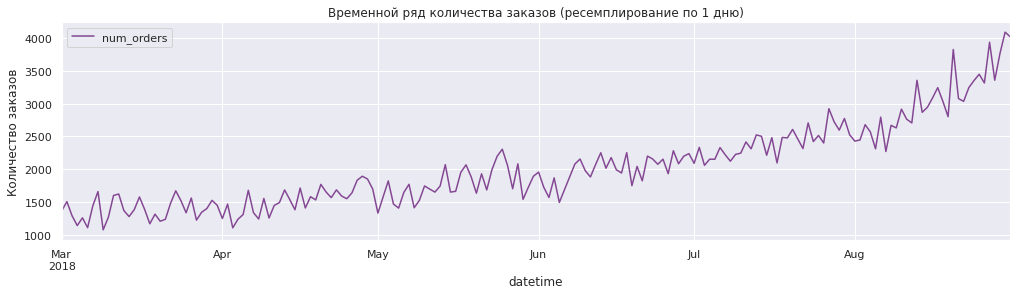

,num_orders
count,184.000000
mean,2026.146739
std,635.874120
min,1076.000000
25%,1547.500000
50%,1911.500000
75%,2349.750000
max,4090.000000


In [19]:
lineplot(df_taxi_res_day, 'Временной ряд количества заказов (ресемплирование по 1 дню)')
df_taxi_res_day.describe()

Имеем данные за 184 дня. Минимальное количество заказов в день - 1076, максимальное - 4090. В среднем имеем 2026 вызовов, медиана - 1911.

**Декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции**. Визуализация:

Составляющие декомпозиции (ресемплирование по 1 дню)


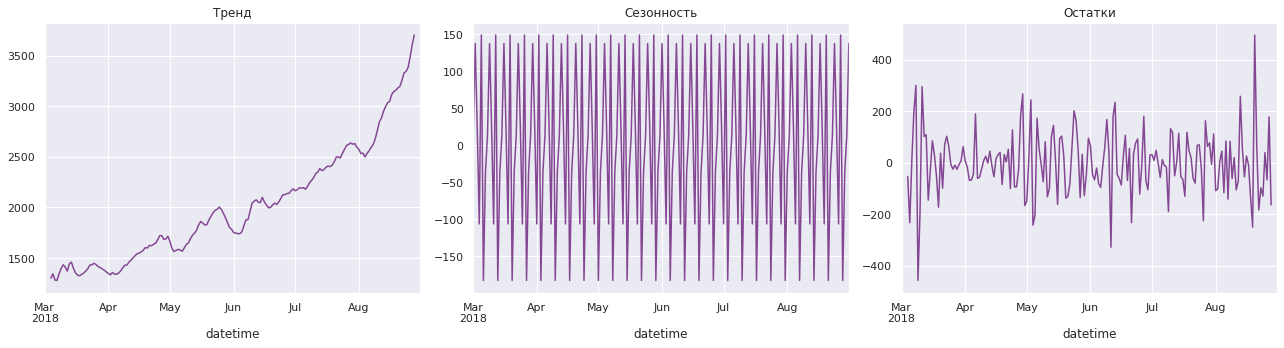

In [20]:
decomposed_day = seasonal_decompose(df_taxi_res_day)

viz_decompose(decomposed_day)
print('Составляющие декомпозиции (ресемплирование по 1 дню)')

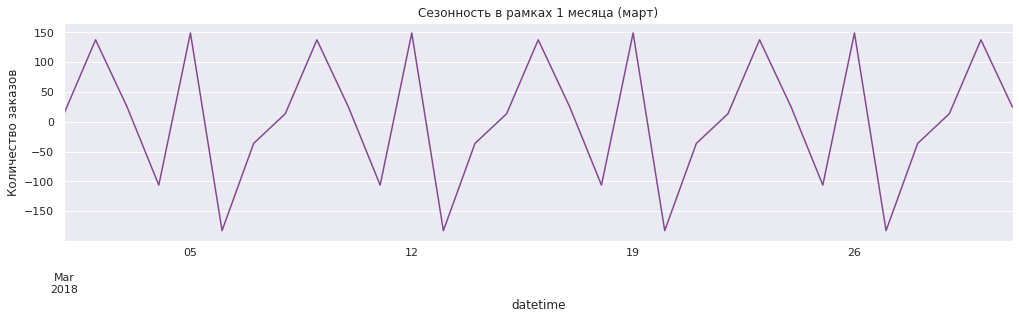

In [21]:
lineplot(decomposed_day.seasonal['2018-03-01':'2018-03-31'], 'Сезонность в рамках 1 месяца (март)')

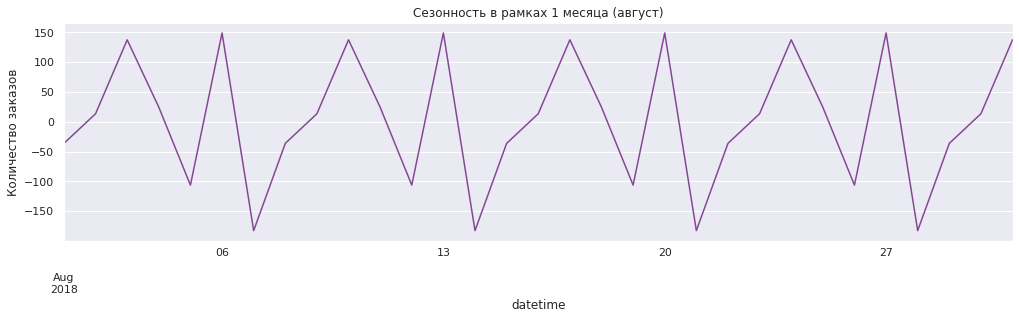

In [22]:
lineplot(decomposed_day.seasonal['2018-08-01':'2018-08-31'], 'Сезонность в рамках 1 месяца (август)')

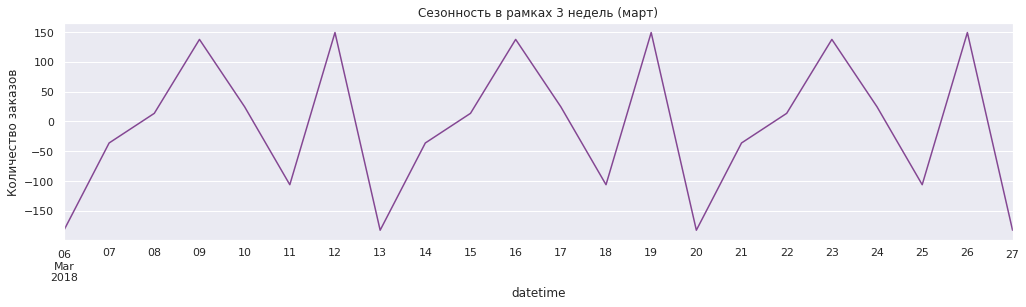

In [23]:
lineplot(decomposed_day.seasonal['2018-03-06':'2018-03-27'], 'Сезонность в рамках 3 недель (март)')

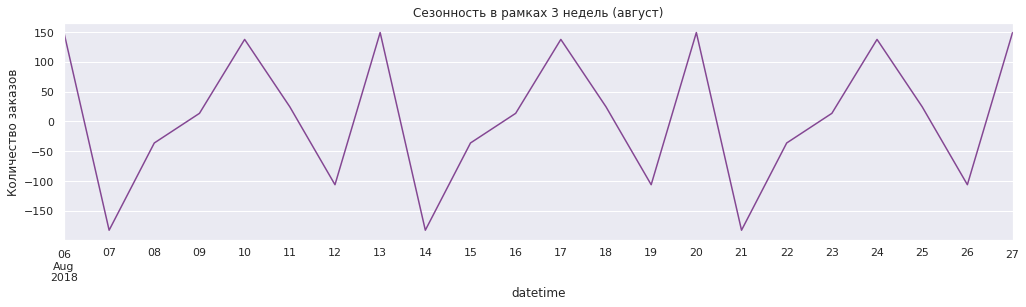

In [24]:
lineplot(decomposed_day.seasonal['2018-08-06':'2018-08-27'], 'Сезонность в рамках 3 недель (август)')

Наблюдаем закономерности по дням недели: наибольший спад по вторникам, пик заказов приходится на ночь пятницы и воскресенья.

**Вывод:** количество заказов такси в аэропорт зависит от месяца (времени года), дня недели и времени суток, поэтому их нужно выделить в отдельные признаки.

**Вывод по разделу:**

**На этапе анализа данных было выполнено:**

1. **Построены графики (визуализация) временного ряда, проанализированы статистические характеристики.** Общее количество часов в данных - 4416 ч. В среднем в час поступает 84 заказа, минимальное количество - ноль, максимальное - 462 заказа. Временной ряд на графике имеет множественные колебания.

2. **Декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции**. Данные составляющие были визуализированы для более детального анализа: увеличение спроса на такси с марта по конец августа. Сильные колебания остатков указывают на наличие пиковых значений. Сезонность была расмотрена в рамках всего периода данных, в рамках месяца и одного дня: цикличная закономерность - количество заказов к вечеру увеличивается, утром идет спад. Наибольший пик идет ближе к 2 часам ночи.

3. **Дополнительно сделано ресемплирование по 1 дню** для анализа зависимости количества вызовов такси от для недели. Имеем данные за 184 дня. Минимальное количество заказов в день - 1076, максимальное - 4090. В среднем имеем 2026 вызовов, медиана - 1911. Проведена декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции, сезонность рассмотрена в рамках 1 месяца и 3 недель по месяцам - март и август. Имеем закономерности по дням недели: наибольший спад по вторникам, пик заказов приходится на ночь пятницы и воскресенья. Вывод: количество заказов такси в аэропорт зависит от дня недели и времени суток, поэтому их нужно выделить в отдельные признаки.

## Обучение моделей

### Подготовка данных

**Создание признаков, необходимых при моделировании**

Функция для добавления признаков:

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    
    # час и день недели
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # отстающие значения, max_lag - максимальный размер отставания
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Используем для моделирования данные, ресэмплированные по 1 часу, т.к. 1 час - это наименьшая единица времени, от которой зависит количество заказов. 

Т.к. видна суточная и недельная сезонность, берем параметры, кратные суткам. Применяем функцию с параметрами:
- max_lag = 24 - максимальное запаздывание;
- rolling_mean_size = 24 - окно скользящего среднего.

Добавляем признаки из даты: час, день, день недели, отстающие значения и скользящее среднее:

In [26]:
make_features(df_taxi_res_hour, 24, 24)

In [27]:
df_taxi_res_hour.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Признаки созданы корректно.

Проверяем типы данных:

In [28]:
df_taxi_res_hour.dtypes

num_orders        int64
hour              int64
dayofweek         int64
lag_1           float64
lag_2           float64
lag_3           float64
lag_4           float64
lag_5           float64
lag_6           float64
lag_7           float64
lag_8           float64
lag_9           float64
lag_10          float64
lag_11          float64
lag_12          float64
lag_13          float64
lag_14          float64
lag_15          float64
lag_16          float64
lag_17          float64
lag_18          float64
lag_19          float64
lag_20          float64
lag_21          float64
lag_22          float64
lag_23          float64
lag_24          float64
rolling_mean    float64
dtype: object

Делим данные на выборки: тренировочную, валидационную и тестовую в соотношении 8:1:1.

In [29]:
train, valid = train_test_split(
    df_taxi_res_hour, 
    shuffle=False, 
    test_size=0.2, 
    random_state=RANDOM_STATE)

valid, test = train_test_split(
    valid, 
    shuffle=False, 
    test_size=0.5, 
    random_state=RANDOM_STATE)

# проверяем разделение на выборки:
print(f'''
Размерность train: {train.shape}
Размерность valid: {valid.shape}
Размерность test: {test.shape}''')


Размерность train: (3532, 28)
Размерность valid: (442, 28)
Размерность test: (442, 28)


Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для тестовой и валидационной выборок взяты с конца обучающей выборки, чтобы исключить наличие пропусков (NaN). Проверяем наличие пропусков:

In [30]:
print(f'''Пропуски в тренировочной выборке: 

{train.isna().sum()}

Пропуски в тестовой выборке: 

{test.isna().sum()}

Пропуски в валидационной выборке: 

{valid.isna().sum()}''')

Пропуски в тренировочной выборке: 

num_orders       0
hour             0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
rolling_mean    24
dtype: int64

Пропуски в тестовой выборке: 

num_orders      0
hour            0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19   

Удаляем строки с пропусками в тренировочной выборке:

In [31]:
train = train.dropna()

print(f'''Проверяем удаление пропусков: 
{train.isna().sum()}''')

Проверяем удаление пропусков: 
num_orders      0
hour            0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64


Пропуски удалены. Делим выборки для обучения на входные и целевой признаки:

In [32]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# проверяем разделение на выборки:
print(f'''
Размерность features_train: {features_train.shape}
Размерность features_valid: {features_valid.shape}
Размерность features_test: {features_test.shape}
Размерность target_train: {target_train.shape}
Размерность target_valid: {target_valid.shape}
Размерность target_test: {target_test.shape}''')


Размерность features_train: (3508, 27)
Размерность features_valid: (442, 27)
Размерность features_test: (442, 27)
Размерность target_train: (3508,)
Размерность target_valid: (442,)
Размерность target_test: (442,)


**Вывод:** данные подготовлены, можно обучать модели.

### Модель LightGBM

Зададим параметры и включим поиск лучших гиперпараметров:

In [33]:
def obj_lgbm(trial):
    # задаем параметры
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'verbosity': -1,
        'n_estimators': 500,
    
        # параметры, которые будем отбирать 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 30, 80),
        'max_depth': trial.suggest_int('max_depth', 5, 12)
    }
    
    # обучаем модель
    model_lgb = lgb.LGBMRegressor(**params)
    model_lgb.fit(features_train,
                  target_train,
                  eval_metric='rmse',
                  eval_set=[(features_valid, target_valid)],
                  callbacks=[early_stopping(stopping_rounds=20)])
                      
    preds = model_lgb.predict(features_valid)
    gini = root_mean_squared_error(target_valid, preds)
    return gini

Запускаем поиск гиперпараметров:

In [34]:
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(obj_lgbm, n_trials=80)

[I 2025-06-13 13:28:24,118] A new study created in memory with name: no-name-4316993a-a4af-4d08-ab62-d00c62612c76


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 30.878


[I 2025-06-13 13:44:41,148] Trial 0 finished with value: 30.87801566368516 and parameters: {'learning_rate': 0.03413608303917502, 'num_leaves': 78, 'max_depth': 10}. Best is trial 0 with value: 30.87801566368516.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[166]	valid_0's rmse: 30.9795


[I 2025-06-13 13:53:12,637] Trial 1 finished with value: 30.979451872627152 and parameters: {'learning_rate': 0.056014382679973516, 'num_leaves': 48, 'max_depth': 10}. Best is trial 0 with value: 30.87801566368516.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 13:54:52,745] Trial 2 finished with value: 32.035418927488784 and parameters: {'learning_rate': 0.3980197110725433, 'num_leaves': 51, 'max_depth': 8}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[11]	valid_0's rmse: 32.0354
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 13:56:07,236] Trial 3 finished with value: 31.750605831245373 and parameters: {'learning_rate': 0.3384318427435159, 'num_leaves': 33, 'max_depth': 8}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[12]	valid_0's rmse: 31.7506
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 13:58:29,544] Trial 4 finished with value: 32.20966772750737 and parameters: {'learning_rate': 0.32701629460375287, 'num_leaves': 79, 'max_depth': 8}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[22]	valid_0's rmse: 32.2097
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 14:00:26,844] Trial 5 finished with value: 31.866287798956535 and parameters: {'learning_rate': 0.49509732959708, 'num_leaves': 56, 'max_depth': 9}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[8]	valid_0's rmse: 31.8663
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 14:02:19,244] Trial 6 finished with value: 32.27104646230032 and parameters: {'learning_rate': 0.41317887410799825, 'num_leaves': 66, 'max_depth': 12}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[11]	valid_0's rmse: 32.271
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 14:05:03,355] Trial 7 finished with value: 31.86278602831778 and parameters: {'learning_rate': 0.18720456707711594, 'num_leaves': 40, 'max_depth': 6}. Best is trial 0 with value: 30.87801566368516.


Early stopping, best iteration is:
[49]	valid_0's rmse: 31.8628
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[187]	valid_0's rmse: 30.8099


[I 2025-06-13 14:15:33,343] Trial 8 finished with value: 30.80986585575267 and parameters: {'learning_rate': 0.04158383391475686, 'num_leaves': 50, 'max_depth': 7}. Best is trial 8 with value: 30.80986585575267.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 14:17:53,150] Trial 9 finished with value: 32.948720579278636 and parameters: {'learning_rate': 0.4497510839899382, 'num_leaves': 65, 'max_depth': 9}. Best is trial 8 with value: 30.80986585575267.


Early stopping, best iteration is:
[11]	valid_0's rmse: 32.9487
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 14:20:21,539] Trial 10 finished with value: 30.930684764496295 and parameters: {'learning_rate': 0.14759965825915633, 'num_leaves': 40, 'max_depth': 5}. Best is trial 8 with value: 30.80986585575267.


Early stopping, best iteration is:
[75]	valid_0's rmse: 30.9307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 30.9103


[I 2025-06-13 14:55:45,540] Trial 11 finished with value: 30.91032381614395 and parameters: {'learning_rate': 0.0169754940960782, 'num_leaves': 75, 'max_depth': 11}. Best is trial 8 with value: 30.80986585575267.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[173]	valid_0's rmse: 30.7374


[I 2025-06-13 15:02:40,651] Trial 12 finished with value: 30.73743408378 and parameters: {'learning_rate': 0.10338056470266963, 'num_leaves': 60, 'max_depth': 6}. Best is trial 12 with value: 30.73743408378.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:06:37,336] Trial 13 finished with value: 31.407166713443768 and parameters: {'learning_rate': 0.12274390149656422, 'num_leaves': 60, 'max_depth': 6}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[67]	valid_0's rmse: 31.4072
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:08:27,546] Trial 14 finished with value: 31.785136711308933 and parameters: {'learning_rate': 0.21373340136302718, 'num_leaves': 46, 'max_depth': 6}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[32]	valid_0's rmse: 31.7851
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:14:22,354] Trial 15 finished with value: 30.9878411311588 and parameters: {'learning_rate': 0.0987962590324965, 'num_leaves': 69, 'max_depth': 7}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[99]	valid_0's rmse: 30.9878
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:16:47,940] Trial 16 finished with value: 31.499855249006245 and parameters: {'learning_rate': 0.2667653568052188, 'num_leaves': 58, 'max_depth': 7}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[28]	valid_0's rmse: 31.4999
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:21:38,337] Trial 17 finished with value: 31.21064832050226 and parameters: {'learning_rate': 0.07795895009360651, 'num_leaves': 53, 'max_depth': 5}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[165]	valid_0's rmse: 31.2106
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:24:25,939] Trial 18 finished with value: 31.973071596450445 and parameters: {'learning_rate': 0.18434912553733485, 'num_leaves': 42, 'max_depth': 7}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[42]	valid_0's rmse: 31.9731
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:26:04,343] Trial 19 finished with value: 30.91757038522532 and parameters: {'learning_rate': 0.24390794040107414, 'num_leaves': 34, 'max_depth': 5}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[48]	valid_0's rmse: 30.9176
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 30.8955


[I 2025-06-13 15:29:56,448] Trial 20 finished with value: 30.89545724907865 and parameters: {'learning_rate': 0.1392305690140374, 'num_leaves': 62, 'max_depth': 7}. Best is trial 12 with value: 30.73743408378.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[366]	valid_0's rmse: 30.8973


[I 2025-06-13 15:54:01,156] Trial 21 finished with value: 30.89734737466319 and parameters: {'learning_rate': 0.017135416480495724, 'num_leaves': 70, 'max_depth': 11}. Best is trial 12 with value: 30.73743408378.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:03,935] Trial 22 finished with value: 30.758239269392877 and parameters: {'learning_rate': 0.05369964329294051, 'num_leaves': 79, 'max_depth': 10}. Best is trial 12 with value: 30.73743408378.


Early stopping, best iteration is:
[113]	valid_0's rmse: 30.7582
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:06,335] Trial 23 finished with value: 30.64923292998731 and parameters: {'learning_rate': 0.07393018944200558, 'num_leaves': 72, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[119]	valid_0's rmse: 30.6492
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:10,540] Trial 24 finished with value: 30.86872138181377 and parameters: {'learning_rate': 0.08795400252815738, 'num_leaves': 72, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[203]	valid_0's rmse: 30.8687
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:12,340] Trial 25 finished with value: 31.21723038536384 and parameters: {'learning_rate': 0.15918762810404202, 'num_leaves': 74, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[83]	valid_0's rmse: 31.2172
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:14,237] Trial 26 finished with value: 30.97612062114122 and parameters: {'learning_rate': 0.10794358605327972, 'num_leaves': 80, 'max_depth': 11}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[52]	valid_0's rmse: 30.9761
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:16,637] Trial 27 finished with value: 31.156339016748724 and parameters: {'learning_rate': 0.06863769589562586, 'num_leaves': 66, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[72]	valid_0's rmse: 31.1563
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:17,840] Trial 28 finished with value: 31.954859677989973 and parameters: {'learning_rate': 0.2712117729636642, 'num_leaves': 76, 'max_depth': 12}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[17]	valid_0's rmse: 31.9549
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:20,543] Trial 29 finished with value: 31.028367815567012 and parameters: {'learning_rate': 0.04759137350756521, 'num_leaves': 63, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[150]	valid_0's rmse: 31.0284
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:21,641] Trial 30 finished with value: 31.394545382158896 and parameters: {'learning_rate': 0.17798217414988843, 'num_leaves': 70, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[37]	valid_0's rmse: 31.3945
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:24,151] Trial 31 finished with value: 31.192241090098985 and parameters: {'learning_rate': 0.044041734521644976, 'num_leaves': 77, 'max_depth': 6}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[216]	valid_0's rmse: 31.1922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 31.0926


[I 2025-06-13 15:54:31,952] Trial 32 finished with value: 31.092555562944426 and parameters: {'learning_rate': 0.01449062570268922, 'num_leaves': 50, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:33,742] Trial 33 finished with value: 31.041095596994886 and parameters: {'learning_rate': 0.061086537199438795, 'num_leaves': 46, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[122]	valid_0's rmse: 31.0411
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:35,445] Trial 34 finished with value: 31.165472168605415 and parameters: {'learning_rate': 0.11012057973249897, 'num_leaves': 55, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[95]	valid_0's rmse: 31.1655
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:38,744] Trial 35 finished with value: 31.007727799257953 and parameters: {'learning_rate': 0.04596765904442759, 'num_leaves': 80, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[144]	valid_0's rmse: 31.0077
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:41,044] Trial 36 finished with value: 30.994665269459034 and parameters: {'learning_rate': 0.07375961692527912, 'num_leaves': 72, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[90]	valid_0's rmse: 30.9947
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:42,243] Trial 37 finished with value: 31.42677498266782 and parameters: {'learning_rate': 0.11897997262007859, 'num_leaves': 51, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[47]	valid_0's rmse: 31.4268
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:42,745] Trial 38 finished with value: 32.11873812035005 and parameters: {'learning_rate': 0.32936275416432287, 'num_leaves': 58, 'max_depth': 6}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[21]	valid_0's rmse: 32.1187
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 31.1435


[I 2025-06-13 15:54:46,746] Trial 39 finished with value: 31.14351692088962 and parameters: {'learning_rate': 0.03142421860440009, 'num_leaves': 67, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:47,844] Trial 40 finished with value: 32.81211171544111 and parameters: {'learning_rate': 0.29448825670585244, 'num_leaves': 47, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[27]	valid_0's rmse: 32.8121
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:49,644] Trial 41 finished with value: 31.270821420131192 and parameters: {'learning_rate': 0.08860748027264434, 'num_leaves': 73, 'max_depth': 11}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[62]	valid_0's rmse: 31.2708
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:52,340] Trial 42 finished with value: 30.854903577787088 and parameters: {'learning_rate': 0.08791544022790411, 'num_leaves': 77, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[112]	valid_0's rmse: 30.8549
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:54,250] Trial 43 finished with value: 31.21133359502456 and parameters: {'learning_rate': 0.14048794158423544, 'num_leaves': 78, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[51]	valid_0's rmse: 31.2113
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:54:59,952] Trial 44 finished with value: 30.96778286315138 and parameters: {'learning_rate': 0.060399212774790934, 'num_leaves': 77, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[134]	valid_0's rmse: 30.9678
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:01,137] Trial 45 finished with value: 30.91936623415957 and parameters: {'learning_rate': 0.21807363694712864, 'num_leaves': 75, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[42]	valid_0's rmse: 30.9194
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:05,942] Trial 46 finished with value: 30.93692954550783 and parameters: {'learning_rate': 0.031919620942109185, 'num_leaves': 68, 'max_depth': 11}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[206]	valid_0's rmse: 30.9369
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:06,637] Trial 47 finished with value: 32.492792364163165 and parameters: {'learning_rate': 0.3890566293865052, 'num_leaves': 44, 'max_depth': 12}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[16]	valid_0's rmse: 32.4928
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:07,939] Trial 48 finished with value: 31.372467808250853 and parameters: {'learning_rate': 0.16136180643034903, 'num_leaves': 63, 'max_depth': 6}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[78]	valid_0's rmse: 31.3725
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:08,837] Trial 49 finished with value: 31.01435185306906 and parameters: {'learning_rate': 0.1321041996662156, 'num_leaves': 49, 'max_depth': 5}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[91]	valid_0's rmse: 31.0144
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:10,437] Trial 50 finished with value: 31.277137206723435 and parameters: {'learning_rate': 0.09691093065116833, 'num_leaves': 52, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[109]	valid_0's rmse: 31.2771
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:14,337] Trial 51 finished with value: 31.088287877388954 and parameters: {'learning_rate': 0.08737057007224355, 'num_leaves': 70, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[104]	valid_0's rmse: 31.0883
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:16,143] Trial 52 finished with value: 31.178690199467837 and parameters: {'learning_rate': 0.07993889267810203, 'num_leaves': 73, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[66]	valid_0's rmse: 31.1787
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[384]	valid_0's rmse: 30.9649


[I 2025-06-13 15:55:24,150] Trial 53 finished with value: 30.964940431375343 and parameters: {'learning_rate': 0.0315205683160195, 'num_leaves': 72, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:25,345] Trial 54 finished with value: 31.363404467761487 and parameters: {'learning_rate': 0.12234395125008776, 'num_leaves': 54, 'max_depth': 11}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[36]	valid_0's rmse: 31.3634
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:28,453] Trial 55 finished with value: 30.973138587588156 and parameters: {'learning_rate': 0.0592962073793475, 'num_leaves': 78, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[129]	valid_0's rmse: 30.9731
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 31.2848


[I 2025-06-13 15:55:44,740] Trial 56 finished with value: 31.28477537287525 and parameters: {'learning_rate': 0.01048146951952475, 'num_leaves': 75, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:45,843] Trial 57 finished with value: 31.473005826932525 and parameters: {'learning_rate': 0.2089084670877061, 'num_leaves': 37, 'max_depth': 10}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[66]	valid_0's rmse: 31.473
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:47,636] Trial 58 finished with value: 30.987330073704953 and parameters: {'learning_rate': 0.10529347808993747, 'num_leaves': 80, 'max_depth': 11}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[57]	valid_0's rmse: 30.9873
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:48,636] Trial 59 finished with value: 30.92344283674359 and parameters: {'learning_rate': 0.15647480176379788, 'num_leaves': 58, 'max_depth': 9}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[34]	valid_0's rmse: 30.9234
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:50,545] Trial 60 finished with value: 30.65997945821124 and parameters: {'learning_rate': 0.07511342019276243, 'num_leaves': 65, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[122]	valid_0's rmse: 30.66
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:52,242] Trial 61 finished with value: 30.860955928017816 and parameters: {'learning_rate': 0.07928293725451298, 'num_leaves': 65, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[94]	valid_0's rmse: 30.861
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:54,035] Trial 62 finished with value: 30.8061541216661 and parameters: {'learning_rate': 0.07298290355387957, 'num_leaves': 60, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[113]	valid_0's rmse: 30.8062
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:55:58,837] Trial 63 finished with value: 30.9309145336139 and parameters: {'learning_rate': 0.045590658067991084, 'num_leaves': 61, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[209]	valid_0's rmse: 30.9309
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:01,244] Trial 64 finished with value: 31.134628546940352 and parameters: {'learning_rate': 0.06434484739495075, 'num_leaves': 59, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[152]	valid_0's rmse: 31.1346
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:08,543] Trial 65 finished with value: 31.163717952691798 and parameters: {'learning_rate': 0.031072477321386557, 'num_leaves': 64, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[253]	valid_0's rmse: 31.1637
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:09,838] Trial 66 finished with value: 30.904731149625285 and parameters: {'learning_rate': 0.09276922463158407, 'num_leaves': 56, 'max_depth': 6}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[108]	valid_0's rmse: 30.9047
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:11,642] Trial 67 finished with value: 31.048849240729034 and parameters: {'learning_rate': 0.1122584590392115, 'num_leaves': 60, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[72]	valid_0's rmse: 31.0488
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:13,443] Trial 68 finished with value: 31.064484101078683 and parameters: {'learning_rate': 0.05447813190842016, 'num_leaves': 56, 'max_depth': 6}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[131]	valid_0's rmse: 31.0645
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:14,043] Trial 69 finished with value: 33.224104928579386 and parameters: {'learning_rate': 0.4859881649613706, 'num_leaves': 69, 'max_depth': 7}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[12]	valid_0's rmse: 33.2241
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:16,143] Trial 70 finished with value: 30.708219840534504 and parameters: {'learning_rate': 0.07185165022465416, 'num_leaves': 61, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[115]	valid_0's rmse: 30.7082
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:18,437] Trial 71 finished with value: 30.960106801639416 and parameters: {'learning_rate': 0.07270742457211772, 'num_leaves': 62, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[101]	valid_0's rmse: 30.9601
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:19,638] Trial 72 finished with value: 30.81916961032307 and parameters: {'learning_rate': 0.1282473876091853, 'num_leaves': 60, 'max_depth': 8}. Best is trial 23 with value: 30.64923292998731.


Early stopping, best iteration is:
[48]	valid_0's rmse: 30.8192
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:21,041] Trial 73 finished with value: 30.42911206540113 and parameters: {'learning_rate': 0.12603718284568363, 'num_leaves': 61, 'max_depth': 8}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[74]	valid_0's rmse: 30.4291
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 30.9738


[I 2025-06-13 15:56:26,154] Trial 74 finished with value: 30.973753074131803 and parameters: {'learning_rate': 0.023184187788659077, 'num_leaves': 57, 'max_depth': 8}. Best is trial 73 with value: 30.42911206540113.


Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:29,253] Trial 75 finished with value: 31.012144860653724 and parameters: {'learning_rate': 0.047576882256517725, 'num_leaves': 66, 'max_depth': 7}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[209]	valid_0's rmse: 31.0121
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:30,746] Trial 76 finished with value: 31.44123618451253 and parameters: {'learning_rate': 0.10257241683560418, 'num_leaves': 64, 'max_depth': 8}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[76]	valid_0's rmse: 31.4412
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:32,750] Trial 77 finished with value: 31.312671356144133 and parameters: {'learning_rate': 0.06720507616821031, 'num_leaves': 53, 'max_depth': 8}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[102]	valid_0's rmse: 31.3127
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:33,742] Trial 78 finished with value: 31.523998578580475 and parameters: {'learning_rate': 0.14981957890357356, 'num_leaves': 62, 'max_depth': 7}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[47]	valid_0's rmse: 31.524
Training until validation scores don't improve for 20 rounds


[I 2025-06-13 15:56:35,753] Trial 79 finished with value: 31.156418380649747 and parameters: {'learning_rate': 0.038580769908686245, 'num_leaves': 67, 'max_depth': 5}. Best is trial 73 with value: 30.42911206540113.


Early stopping, best iteration is:
[253]	valid_0's rmse: 31.1564


Лучшие гиперпараметры для LightGBM:

In [35]:
best_lgbm = lgb.LGBMRegressor(**study_lgbm.best_params)
best_lgbm

LGBMRegressor(learning_rate=0.12603718284568363, max_depth=8, num_leaves=61)

Обучаем модель на лучших гиперпараметрах:

In [36]:
# включаем счетчик на обучение
start_time = time.time()

best_lgbm.fit(features_train, target_train)

# останавливаем время
end_time = time.time()
train_time_lgb = end_time - start_time

print(f'''Время обучения LightGBM: {train_time_lgb} секунд ''')

Время обучения LightGBM: 1.5648930072784424 секунд 


Получим предсказания:

In [37]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_lgb = best_lgbm.predict(features_valid)

# останавливаем счетчик
end_time = time.time()
predict_time_lgb = end_time - start_time

print(f'''Время предсказания LightGBM: {predict_time_lgb} секунд ''')

Время предсказания LightGBM: 0.00648188591003418 секунд 


Оценим качество модели метрикой RMSE на валидационной выборке:

In [38]:
rmse_lgb = root_mean_squared_error(target_valid, y_pred_lgb)

print(f'''RMSE на валидационной выборке LightGBM: {rmse_lgb:.2f} ''')

RMSE на валидационной выборке LightGBM: 30.49 


**Вывод**: с помощью OptunaSearchCV найдены лучшие гиперпараметры для модели градиентного бустинга LightGBM: 

**LGBMRegressor(learning_rate=0.12603718284568363, max_depth=8, num_leaves=61)**
              
Время обучения модели с лучшими гиперпараметрами составило 1.56 секунд. **Метрика RMSE на валидационной выборке равна 30.49.**

### Модель LinearRegression

Создаем список с названиями количественных признаков для масштабирования и категориальных для кодирования:

In [72]:
# количественные признаки
num_columns = list(df_taxi_res_hour.drop(columns=['num_orders', 'hour', 'dayofweek']).select_dtypes(
    include=['int', 'float']).columns)

# категориальные признаки
cat_columns = ['hour', 'dayofweek']

Копируем выборки с признаками для обработки:

In [73]:
features_train_scaler_ohe = features_train.copy()
features_valid_scaler_ohe = features_valid.copy()
features_test_scaler_ohe = features_test.copy()

Создаем пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder):

In [74]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

Создаем общий пайплайн подготовки данных data_preprocessor, который объединит пайплайн обработки категориальных признаков и масштабирование количественных признаков:

In [75]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)
    ], remainder = 'passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['hour', 'dayofweek']),
                                ('num', MinMaxScaler(),
                                 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                                  'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
                                  'lag_11', 'lag_12', 'lag_13', 'lag_14',
                                  'lag_15', 'lag_16', 'lag_17', 'lag_18',
                                  'lag_19', 'lag_20', 'lag_21', 'lag_22',
                                  'lag_23', 'lag_24', 'rolling_mean'])])

Cоздаем итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели линейной регрессии:

In [76]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression(n_jobs=-1))
    ]
)

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'rolling_mean'])])),
                ('models', LinearRegression(n_jobs=-1))])

Создаем словарь для подбора метода подготовки данных:

In [77]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
] 

param_grid

[{'models': [LinearRegression(n_jobs=-1)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

Для поиска лучшей модели с гиперпараметрами используем поиск по сетке GridSearchCV, в качестве метрики используем RMSE:

In [80]:
grid_search_lr = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
grid_search_lr.fit(features_train_scaler_ohe, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['hour',
                                                                          'dayofweek']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3...
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_16',
                                                                          'lag_17',
                                                                          'lag_18',
                                                                          'lag_19',
                                                                          'lag_20',
                                                                          'lag_21',
                                                                          'lag_22',
                                                                          'lag_23',
                                                                          'lag_24',
                                                                          'rolling_mean'])])),
                                       ('models',
                                        LinearRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [81]:
print('Лучшая модель и её параметры:\n\n', grid_search_lr.best_params_)

Лучшая модель и её параметры:

 {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}


Сохраняем лучшую модель:

In [82]:
best_lr = grid_search_lr.best_estimator_
best_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', 'passthrough',
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'rolling_mean'])])),
                ('models', LinearRegression(n_jobs=-1))])

Обучаем модель:

In [83]:
# включаем счетчик
start_time = time.time()

# обучаем модель
best_lr.fit(features_train_scaler_ohe, target_train)

# останавливаем время
end_time = time.time()
train_time_lr = end_time - start_time

print(f'''Время обучения LinearRegression: {train_time_lr} секунд ''')

# рассчитываем метрику RMSE на кросс-валидации
rmse_train_lr = abs(cross_val_score(best_lr, features_train_scaler_ohe, 
                                    target_train, cv=5, 
                                    scoring='neg_root_mean_squared_error').mean())

print(f'''RMSE модели LinearRegression на кросс-валидации: {rmse_train_lr:.2f} ''')

Время обучения LinearRegression: 0.019321441650390625 секунд 
RMSE модели LinearRegression на кросс-валидации: 22.90 


Рассчитаем метрику RMSE на валидационной выборке:

In [84]:
# включаем счетчик
start_time = time.time()

# получаем предсказания
best_lr.predict(features_valid_scaler_ohe)

# останавливаем время
end_time = time.time()
predict_time_lr = end_time - start_time

print(f'''Время предсказания LinearRegression: {predict_time_lr} секунд ''')

Время предсказания LinearRegression: 0.00852060317993164 секунд 


Оценим качество модели метрикой RMSE на валидационной выборке:

In [85]:
# рассчитываем метрику
rmse_lr = root_mean_squared_error(target_valid, best_lr.predict(features_valid_scaler_ohe))

print(f'''RMSE на валидационной выборке LinearRegression: {rmse_lr:.2f} ''')

RMSE на валидационной выборке LinearRegression: 32.06 


**Вывод**: c помощью пайплайна и автоматизированного поиска по сетке было выполнено:

- кодирование категориальных признаков с помощью OneHotEncoder;
- перебирался вариант масштабирования количнственных признаков с помощью StandardScaler и MinMaxScaler, и без масштабирования.

Найдена лучшая модель: LinearRegression(n_jobs=-1) без масштабирования количественных признаков.
Модель была обучена. 

Время обучения составило 0.019 секунд, **метрика RMSE на валидационной выборке равна 32.06.**

### Модель DecisionTreeRegressor

Модель дерева решений не требует масштабирования количественных признаков, поэтому используем признаки без масштабирования. Зададим параметры и включим поиск лучших гиперпараметров:

In [51]:
# задаем параметры, которые будем отбирать
param_grid = {
        'max_depth': range(2, 10),
        'max_features': range(2, 10),
        'min_samples_split': range(2, 7)}

# инициализируем модель
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

tscv = TimeSeriesSplit(n_splits=5)

# инициализируем класс для автоматизированного поиска гиперпараметров
grid_search = GridSearchCV(
    model_tree,
    param_grid,
    cv=tscv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 7)},
             scoring='neg_root_mean_squared_error')

Лучшие гиперпараметры для DecisionTreeRegressor:

In [52]:
best_tree = grid_search.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, random_state=42)

Обучаем модель на лучших гиперпараметрах:

In [53]:
# включаем счетчик на обучение
start_time = time.time()

best_tree.fit(features_train, target_train)

# останавливаем время
end_time = time.time()
train_time_tree = end_time - start_time

print(f'''Время обучения DecisionTreeRegressor: {train_time_tree} секунд ''')

Время обучения DecisionTreeRegressor: 0.023233890533447266 секунд 


Получим предсказания:

In [54]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_tree = best_tree.predict(features_valid)

# останавливаем счетчик
end_time = time.time()
predict_time_tree = end_time - start_time

print(f'''Время предсказания DecisionTreeRegressor: {predict_time_tree} секунд ''')

Время предсказания DecisionTreeRegressor: 0.002893209457397461 секунд 


Оценим качество модели метрикой RMSE на валидационной выборке:

In [55]:
rmse_tree = root_mean_squared_error(target_valid, y_pred_tree)

print(f'''RMSE на валидационной выборке DecisionTreeRegressor: {rmse_tree:.2f} ''')

RMSE на валидационной выборке DecisionTreeRegressor: 41.25 


**Вывод**: с помощью GridSearchCV найдены лучшие гиперпараметры для модели дерева решений DecisionTreeRegressor: 

**DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, random_state=42)**
              
Время обучения модели с лучшими гиперпараметрами составило 0.02 секунд. **Метрика RMSE на валидационной выборке равна 41.25.** 

### Вывод по разделу

**На этапе обучения моделей было выполнено:**

1. **Подготовка данных**. 
- создана функция для добавления признаков, необходимых при моделировании. Использованы для моделирования данные, ресэмплированные по 1 часу, т.к. 1 час - это наименьшая единица времени, от которой зависит количество заказов. Т.к. видна суточная и недельная сезонность, взяты параметры, кратные суткам. Функция для создания признаков применена с параметрами: max_lag = 24 - максимальное запаздывание; rolling_mean_size = 24 - окно скользящего среднего. Добавлены признаки: час, день недели, отстающие значения и скользящее среднее;
- данные разделены на выборки: тренировочную, валидационную и тестовую в соотношении 8:1:1. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для тестовой и валидационной выборок взяты с конца обучающей выборки, чтобы исключить наличие пропусков (NaN). В тренировочной выборке удалены все строки, в которых имеются пропуски (NaN). Выделены из выборки признаки для обучения: входные и целевой.

  
2. **Модель LightGBM**.
- заданы параметры для автоматического поиска гиперпараметров модели; 
- с помощью OptunaSearchCV найдены лучшие гиперпараметры для модели градиентного бустинга LightGBM: 

**LGBMRegressor(learning_rate=0.12603718284568363, max_depth=8, num_leaves=61)**
              
Время обучения модели с лучшими гиперпараметрами составило 1.56 секунд. **Метрика RMSE на валидационной выборке равна 30.49.**

3. **Модель LinearRegression**.
- c помощью пайплайна и автоматизированного поиска по сетке было выполнено:
   - кодирование категориальных признаков с помощью OneHotEncoder;
   - перебирался вариант масштабирования количнственных признаков с помощью StandardScaler и MinMaxScaler, и без масштабирования.
- найдена лучшая модель: LinearRegression(n_jobs=-1) без масштабирования количественных признаков.
Модель была обучена. 

Время обучения составило 0.019 секунд, **метрика RMSE на валидационной выборке равна 32.06.**

4. **Модель DecisionTreeRegressor**.
- модель дерева решений не требует масштабирования количественных признаков, поэтому использованы признаки без масштабирования;
- с помощью автоматизированного поиска GridSearchCV найдены лучшие гиперпараметры для модели DecisionTreeRegressor: 

**DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, random_state=42)**
              
Время обучения модели с лучшими гиперпараметрами составило 0.02 секунд. **Метрика RMSE на валидационной выборке равна 41.25.** 

## Тестирование

Сохраним результаты обучения моделей в таблицу:

In [96]:
df = pd.DataFrame(columns=['LightGBM', 'LinearRegression', 'DecisionTreeRegressor'])
df.loc['Время обучения (сек)'] = [train_time_lgb, train_time_lr, train_time_tree]
df.loc['Время предсказания (сек)'] = [predict_time_lgb, predict_time_lr, predict_time_tree]
df.loc['Метрика RMSE на валид.выборке'] = [rmse_lgb, rmse_lr, rmse_tree]
df

,LightGBM,LinearRegression,DecisionTreeRegressor
Время обучения (сек),1.564893,0.019321,0.023234
Время предсказания (сек),0.006482,0.008521,0.002893
Метрика RMSE на валид.выборке,30.489213,32.059910,41.248421


Среди трех моделей - LightGBM, LinearRegression и DecisionTreeRegressor наиболее лучшая по:

- времени обучения - LinearRegression;
- времени предсказания - DecisionTreeRegressor; 
- качеству предсказаний - LightGBM.

Сделаем предсказание на тестовой выборке лучшей моделью по качеству - LightGBM и рассчитаем метрику RMSE на тестовых данных:

In [97]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_lgb_test = best_lgbm.predict(features_test)

# останавливаем счетчик
end_time = time.time()
predict_time_lgb_test = end_time - start_time

print(f'''Время предсказания на тестовых данных LightGBM: {predict_time_lgb_test} секунд ''')

rmse_lgb_test = root_mean_squared_error(target_test, y_pred_lgb_test)

print(f'''RMSE на тестовой выборке LightGBM: {rmse_lgb_test:.2f} ''')

Время предсказания на тестовых данных LightGBM: 0.01227879524230957 секунд 
RMSE на тестовой выборке LightGBM: 49.79 


**Критерий качества - метрика RMSE < 48 - не достигнут**.

Сделаем предсказание на тестовой выборке лучшей моделью по времени обучения - LinearRegression и рассчитаем метрику RMSE на тестовых данных:

In [98]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_lr_test = best_lr.predict(features_test)

# останавливаем счетчик
end_time = time.time()
predict_time_lr_test = end_time - start_time

print(f'''Время предсказания на тестовых данных LinearRegression: {predict_time_lr_test} секунд ''')

rmse_lr_test = root_mean_squared_error(target_test, y_pred_lr_test)

print(f'''RMSE на тестовой выборке LinearRegression: {rmse_lr_test:.2f} ''')

Время предсказания на тестовых данных LinearRegression: 0.018156766891479492 секунд 
RMSE на тестовой выборке LinearRegression: 43.30 


**Критерий качества - метрика RMSE < 48 - достигнут**.

**Лучшая модель по времени обучения и качеству на тестовых данных - LinearRegression(n_jobs=-1) с кодированием категориальных признаков, без масштабирования количественных. Метрика RMSE на тестовой выборке: 43.30.**

**Вывод:** среди трех моделей - LightGBM, LinearRegression и DecisionTreeRegressor наиболее лучшая на валидационной выборке по:

- времени обучения - LinearRegression;
- времени предсказания - DecisionTreeRegressor; 
- качеству предсказаний - LightGBM.

**Критерий качества - метрика RMSE < 48 - достигнут**.

**Лучшая модель по времени обучения и качеству на тестовых данных - LinearRegression(n_jobs=-1) с кодированием категориальных признаков, без масштабирования количественных. Метрика RMSE на тестовой выборке: 43.30.**

## Общий вывод

**РЕАЛИЗАЦИЯ ЗАДАЧИ ПО ЭТАПАМ**:

**ЭТАП 1. Подготовка данных**.

1. **Загрузка данных, изучение информации**. Файл загружен в датафрейм (df_taxi), который имеет 26496 строк, 2 столбца (дата и количество заказов). Пропусков нет, наименование столбцов корректное. Интервал временной в данных - каждые 10 минут.

2. **Проверка наличия явных дубликатов.** Отсутствуют.

3. **Перезапись файла в датафрейм, назначив даты индексом.** Успешно выполнено.

4. **Проверка индексов на монотонность (хронологический порядок)**. Хронологический порядок соблюден.

5. **Созданы функции для визуализации данных**.

6. **Визуализировано общее распределение заказов и выведены статистические характеристики**. Минимальное количество заказов - ноль, максимальное - 119 заказов. Среднее - 14 заказов, медиана - 13 заказов. Отклонений в значениях нет.

7. **Ресемплирование данных по одному часу и подсчет суммарного значения для каждой группы**. Успешно выполнено.

**ЭТАП 2. Анализ данных**.

1. **Построены графики (визуализация) временного ряда, проанализированы статистические характеристики.** Общее количество часов в данных - 4416 ч. В среднем в час поступает 84 заказа, минимальное количество - ноль, максимальное - 462 заказа. Временной ряд на графике имеет множественные колебания.

2. **Декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции**. Данные составляющие были визуализированы для более детального анализа: увеличение спроса на такси с марта по конец августа. Сильные колебания остатков указывают на наличие пиковых значений. Сезонность была расмотрена в рамках всего периода данных, в рамках месяца и одного дня: цикличная закономерность - количество заказов к вечеру увеличивается, утром идет спад. Наибольший пик идет ближе к 2 часам ночи.

3. **Дополнительно сделано ресемплирование по 1 дню** для анализа зависимости количества вызовов такси от для недели. Имеем данные за 184 дня. Минимальное количество заказов в день - 1076, максимальное - 4090. В среднем имеем 2026 вызовов, медиана - 1911. Проведена декомпозиция данных на трендовую, сезонную составляющие и остаток декомпозиции, сезонность рассмотрена в рамках 1 месяца и 3 недель по месяцам - март и август. Имеем закономерности по дням недели: наибольший спад по вторникам, пик заказов приходится на ночь пятницы и воскресенья. Вывод: количество заказов такси в аэропорт зависит от дня недели и времени суток, поэтому их нужно выделить в отдельные признаки.

**ЭТАП 3. Обучение моделей**.

1. **Подготовка данных**. 
- создана функция для добавления признаков, необходимых при моделировании. Использованы для моделирования данные, ресэмплированные по 1 часу, т.к. 1 час - это наименьшая единица времени, от которой зависит количество заказов. Т.к. видна суточная и недельная сезонность, взяты параметры, кратные суткам. Функция для создания признаков применена с параметрами: max_lag = 24 - максимальное запаздывание; rolling_mean_size = 24 - окно скользящего среднего. Добавлены признаки: час, день недели, отстающие значения и скользящее среднее;
- данные разделены на выборки: тренировочную, валидационную и тестовую в соотношении 8:1:1. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для тестовой и валидационной выборок взяты с конца обучающей выборки, чтобы исключить наличие пропусков (NaN). В тренировочной выборке удалены все строки, в которых имеются пропуски (NaN). Выделены из выборки признаки для обучения: входные и целевой.

  
2. **Модель LightGBM**.
- заданы параметры для автоматического поиска гиперпараметров модели; 
- с помощью OptunaSearchCV найдены лучшие гиперпараметры для модели градиентного бустинга LightGBM: 

**LGBMRegressor(learning_rate=0.12603718284568363, max_depth=8, num_leaves=61)**
              
Время обучения модели с лучшими гиперпараметрами составило 1.56 секунд. **Метрика RMSE на валидационной выборке равна 30.49.**

3. **Модель LinearRegression**.
С помощью пайплайна и автоматизированного поиска по сетке было выполнено:

- кодирование категориальных признаков с помощью OneHotEncoder;
- перебирался вариант масштабирования количнственных признаков с помощью StandardScaler и MinMaxScaler, и без масштабирования.

Найдена лучшая модель: LinearRegression(n_jobs=-1) без масштабирования количественных признаков. Модель была обучена.

Время обучения составило 0.019 секунд, **метрика RMSE на валидационной выборке равна 32.06.**

4. **Модель DecisionTreeRegressor**.
- модель дерева решений не требует масштабирования количественных признаков, поэтому использованы признаки без масштабирования;
- с помощью автоматизированного поиска GridSearchCV найдены лучшие гиперпараметры для модели DecisionTreeRegressor: 

**DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, random_state=42)**
              
Время обучения модели с лучшими гиперпараметрами составило 0.02 секунд. **Метрика RMSE на валидационной выборке равна 41.25.** 

**ЭТАП 4. Тестирование моделей**.

Среди трех моделей - LightGBM, LinearRegression и DecisionTreeRegressor наиболее лучшая на валидационной выборке по:

- времени обучения - LinearRegression;
- времени предсказания - DecisionTreeRegressor; 
- качеству предсказаний - LightGBM.

**Критерий качества - метрика RMSE < 48 - достигнут**.

**Лучшая модель по времени обучения и качеству на тестовых данных - LinearRegression(n_jobs=-1) с кодированием категориальных признаков, без масштабирования количественных. Метрика RMSE на тестовой выборке: 43.30.**